In [33]:
import pandas as pd

# Skip the metadata row and use the next row as the header
benefits = pd.read_csv('snap-benefits-8.csv', skiprows=2)

# Check what the actual column names are now
print(benefits.columns.tolist())


['State / Territory', 'May 2024\n', 'April 2025\nPreliminary', 'May 2025\nInitial', 'Percent Change\nMay 2025 vs\nApril 2025', 'Percent Change\nMay 2025 vs\nMay 2024']


In [34]:
import pandas as pd
import re

# You already loaded with skiprows=2
# benefits = pd.read_csv('snap-benefits-8.csv', skiprows=2)

# 1) Normalize column names: strip, collapse whitespace/newlines to single spaces
benefits.columns = (
    benefits.columns
    .str.strip()
    .str.replace(r"\s+", " ", regex=True)  # turn '\n' etc into single space
)

print(benefits.columns.tolist())
# Expect something like:
# ['State / Territory', 'May 2024', 'April 2025 Preliminary', 'May 2025 Initial', 'Percent Change May 2025 vs April 2025', 'Percent Change May 2025 vs May 2024']

# 2) Identify the latest month column automatically (the one ending with 'Initial')
latest_col = [c for c in benefits.columns if re.search(r"\bInitial\b", c)]
if not latest_col:
    raise ValueError("Could not find a column with 'Initial' in its name. Check the headers printed above.")
latest_col = latest_col[0]

# 3) Rename to standard names and keep needed columns
benefits = benefits.rename(columns={
    'State / Territory': 'state',
    latest_col: 'total_benefits'
})[['state', 'total_benefits']]

# 4) Drop national totals or empty state rows
benefits = benefits[~benefits['state'].str.contains('united states', case=False, na=False)]
benefits = benefits.dropna(subset=['state', 'total_benefits'])

# 5) Convert benefits to numeric
benefits['total_benefits'] = (
    benefits['total_benefits']
    .astype(str)
    .str.replace('[\$,]', '', regex=True)
    .str.replace(r'\s+', '', regex=True)
    .replace({'--': pd.NA})
    .astype(float)
)

benefits = benefits.reset_index(drop=True)
benefits.head()


['State / Territory', 'May 2024', 'April 2025 Preliminary', 'May 2025 Initial', 'Percent Change May 2025 vs April 2025', 'Percent Change May 2025 vs May 2024']


,state,total_benefits
0,Alabama,1.421428e+08
1,Alaska,2.418148e+07
2,Arizona,1.617056e+08
3,Arkansas,4.143439e+07
4,California,1.045311e+09


In [35]:
import numpy as np

# Safer numeric conversion for persons column
persons['persons'] = (
    persons['persons']
    .astype(str)
    .str.replace('[\$,]', '', regex=True)
    .str.replace(r'\s+', '', regex=True)
    .replace({'--': np.nan, 'nan': np.nan, '<NA>': np.nan})  # handle NAType strings
)

# Convert to numeric, coercing errors
persons['persons'] = pd.to_numeric(persons['persons'], errors='coerce')

# Drop rows where persons is still NaN
persons = persons.dropna(subset=['persons']).reset_index(drop=True)

persons.info()
persons.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   state    54 non-null     object 
 1   persons  54 non-null     float64
dtypes: float64(1), object(1)
memory usage: 996.0+ bytes


,state,persons
0,Alabama,736178.0
1,Alaska,66377.0
2,Arizona,887253.0
3,Arkansas,239748.0
4,California,5494318.0


In [36]:
snap = benefits.merge(persons, on='state', how='inner')

# (optional) keep only 50 states + DC
states_50_dc = {
    'Alabama','Alaska','Arizona','Arkansas','California','Colorado','Connecticut','Delaware',
    'District Of Columbia','Florida','Georgia','Hawaii','Idaho','Illinois','Indiana','Iowa',
    'Kansas','Kentucky','Louisiana','Maine','Maryland','Massachusetts','Michigan','Minnesota',
    'Mississippi','Missouri','Montana','Nebraska','Nevada','New Hampshire','New Jersey',
    'New Mexico','New York','North Carolina','North Dakota','Ohio','Oklahoma','Oregon',
    'Pennsylvania','Rhode Island','South Carolina','South Dakota','Tennessee','Texas','Utah',
    'Vermont','Virginia','Washington','West Virginia','Wisconsin','Wyoming'
}
snap_usa = snap[snap['state'].isin(states_50_dc)].reset_index(drop=True)

# core metric
snap_usa['benefits_per_person'] = snap_usa['total_benefits'] / snap_usa['persons']

print(snap_usa.shape)
snap_usa.head()


(49, 4)


,state,total_benefits,persons,benefits_per_person
0,Alaska,2.418148e+07,66377.0,364.305091
1,Arizona,1.617056e+08,887253.0,182.254218
2,Arkansas,4.143439e+07,239748.0,172.824762
3,California,1.045311e+09,5494318.0,190.253036
4,Colorado,1.204934e+08,614843.0,195.974270


In [37]:
# rankings
top10 = snap_usa.sort_values('benefits_per_person', ascending=False).head(10)
bot10 = snap_usa.sort_values('benefits_per_person', ascending=True).head(10)

print("Top 10 by benefits per person:")
print(top10[['state','benefits_per_person','total_benefits','persons']])

print("\nBottom 10 by benefits per person:")
print(bot10[['state','benefits_per_person','total_benefits','persons']])

# simple correlations
print("\nCorrelations:")
print(snap_usa[['total_benefits','persons','benefits_per_person']].corr(numeric_only=True))


Top 10 by benefits per person:
            state  benefits_per_person  total_benefits    persons
0          Alaska           364.305091      24181479.0    66377.0
9          Hawaii           361.777541      59178123.0   163576.0
30       New York           218.437195     647210404.0  2962913.0
19  Massachusetts           215.637998     232066810.0  1076187.0
40      Tennessee           203.199231     140318213.0   690545.0
37   Rhode Island           200.949631      28680737.0   142726.0
39   South Dakota           198.235222      14923544.0    75282.0
23       Missouri           196.099626     128629589.0   655940.0
4        Colorado           195.974270     120493408.0   614843.0
11       Illinois           195.938127     368278250.0  1879564.0

Bottom 10 by benefits per person:
            state  benefits_per_person  total_benefits   persons
21      Minnesota           158.454457      71616027.0  451966.0
47      Wisconsin           163.893045     112973934.0  689315.0
46  West Virg

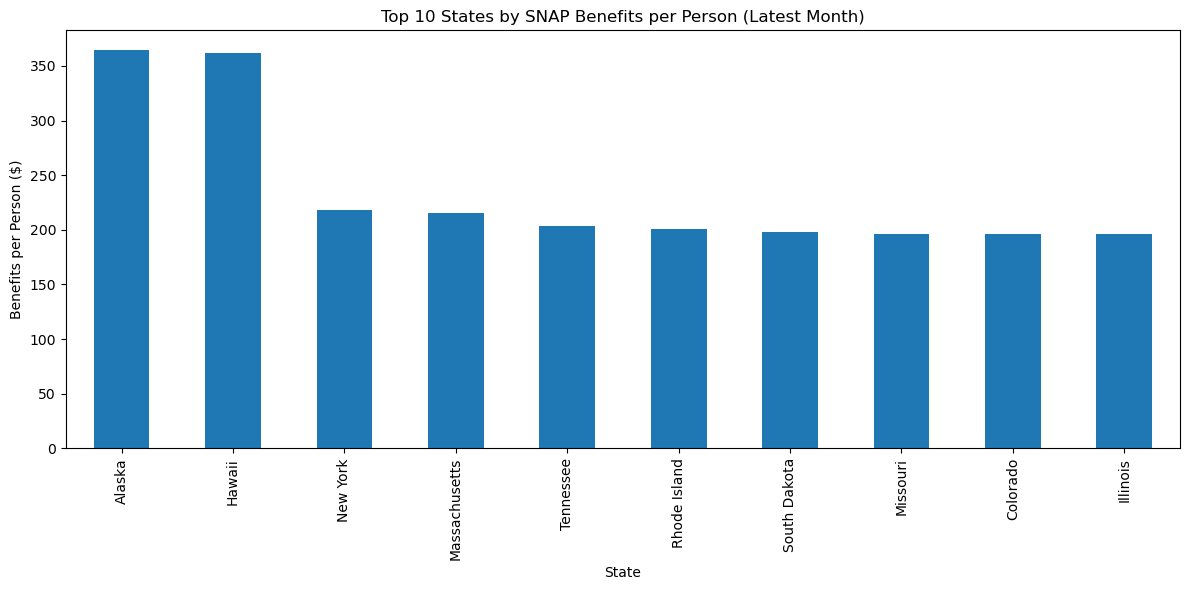

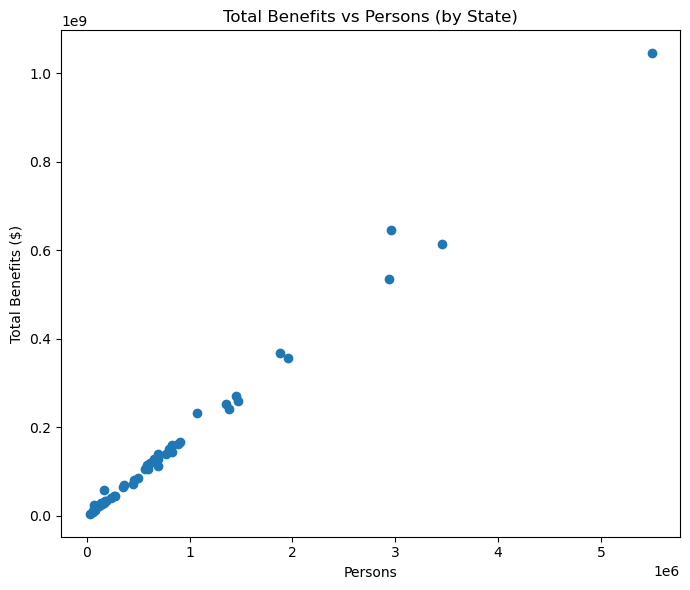

In [38]:
import matplotlib.pyplot as plt

# bar: top 10 by benefits_per_person
ax = top10.plot(kind='bar', x='state', y='benefits_per_person', figsize=(12,6), legend=False)
ax.set_title('Top 10 States by SNAP Benefits per Person (Latest Month)')
ax.set_xlabel('State')
ax.set_ylabel('Benefits per Person ($)')
plt.tight_layout()
plt.show()

# scatter: scale vs reach
plt.figure(figsize=(7,6))
plt.scatter(snap_usa['persons'], snap_usa['total_benefits'])
plt.title('Total Benefits vs Persons (by State)')
plt.xlabel('Persons')
plt.ylabel('Total Benefits ($)')
plt.tight_layout()
plt.show()


### SNAP: State-Level Benefits & Participation (Latest Month)

**Data prep**
- Loaded USDA state-level **Benefits** and **Persons** (latest “Initial” month).
- Collapsed header newlines/spaces, removed national totals, converted money and counts to numeric.
- Merged on `state` and restricted to the 50 states + DC.

**Key derived metric**
- `benefits_per_person = total_benefits / persons` — normalizes spending by caseload, enabling fair comparison across states.

**Quick findings**
- Ranked states by `benefits_per_person` (top/bottom 10).
- Reviewed correlations among `total_benefits`, `persons`, and `benefits_per_person`.
- Visualized (1) top-10 bar chart and (2) scale vs reach scatterplot.

**Next steps**
- Add Census population to compute **benefits per capita** (general population, not just recipients).
- Layer in income/education/race (ACS) to analyze drivers of variation across states.


In [39]:
# Load income data
income = pd.read_csv('ACSDT1Y2024.B19013-Data.csv')

# Inspect columns
print(income.columns)
print(income.head())

Index(['GEO_ID', 'NAME', 'B19013_001E', 'B19013_001M', 'Unnamed: 4'], dtype='object')
        GEO_ID                  NAME  \
0    Geography  Geographic Area Name   
1  0400000US01               Alabama   
2  0400000US02                Alaska   
3  0400000US04               Arizona   
4  0400000US05              Arkansas   

                                         B19013_001E  \
0  Estimate!!Median household income in the past ...   
1                                              66659   
2                                              95665   
3                                              81486   
4                                              62106   

                                         B19013_001M  Unnamed: 4  
0  Margin of Error!!Median household income in th...         NaN  
1                                                780         NaN  
2                                               3278         NaN  
3                                                684         NaN  
4

In [40]:
# replace with your actual filename (e.g., 'ACSST1Y2024.B19013-Data.csv' or similar)
fn = 'ACSDT1Y2024.B19013-Data.csv'

# 1) read as strings first
inc_raw = pd.read_csv(fn, dtype=str)

# 2) Find the state-name column (often 'NAME' or 'Geography')
name_col = None
for cand in ['NAME','Geography','name','geography']:
    if cand in inc_raw.columns:
        name_col = cand
        break
if name_col is None:
    raise ValueError("Could not find a state name column ('NAME' or 'Geography').")

# 3) Find the income estimate column (variable id ending with _001E, e.g., B19013_001E)
est_cols = [c for c in inc_raw.columns if re.search(r'_001E$', c)]
if not est_cols:
    # sometimes the file has a two-row header; try using the second row as header
    inc_raw2 = pd.read_csv(fn, dtype=str, header=1)
    est_cols = [c for c in inc_raw2.columns if re.search(r'_001E$', c)]
    if est_cols:
        inc_raw = inc_raw2
    else:
        raise ValueError("Could not find an ACS estimate column ending with '_001E' (e.g., B19013_001E).")
est_col = est_cols[0]

# 4) Build a clean frame
income = inc_raw[[name_col, est_col]].rename(columns={name_col: 'state', est_col: 'median_income'})

# 5) Drop any label/header rows accidentally included (non-numeric income)
income['median_income'] = pd.to_numeric(income['median_income'], errors='coerce')
income = income.dropna(subset=['median_income'])

# 6) Normalize state names and keep relevant geographies later if you wish
income['state'] = income['state'].str.strip().str.title()

income = income.reset_index(drop=True)
print(income.head(), income.shape)


        state  median_income
0     Alabama        66659.0
1      Alaska        95665.0
2     Arizona        81486.0
3    Arkansas        62106.0
4  California       100149.0 (52, 2)


In [41]:
states_to_keep = persons['state'].str.strip().str.title().unique()
income = income[income['state'].isin(states_to_keep)].reset_index(drop=True)


In [42]:
snap_income = snap_usa.merge(income, on='state', how='inner')
print(snap_income[['state','benefits_per_person','median_income']].head())


        state  benefits_per_person  median_income
0      Alaska           364.305091        95665.0
1     Arizona           182.254218        81486.0
2    Arkansas           172.824762        62106.0
3  California           190.253036       100149.0
4    Colorado           195.974270        97113.0


                     benefits_per_person  median_income
benefits_per_person             1.000000       0.358678
median_income                   0.358678       1.000000


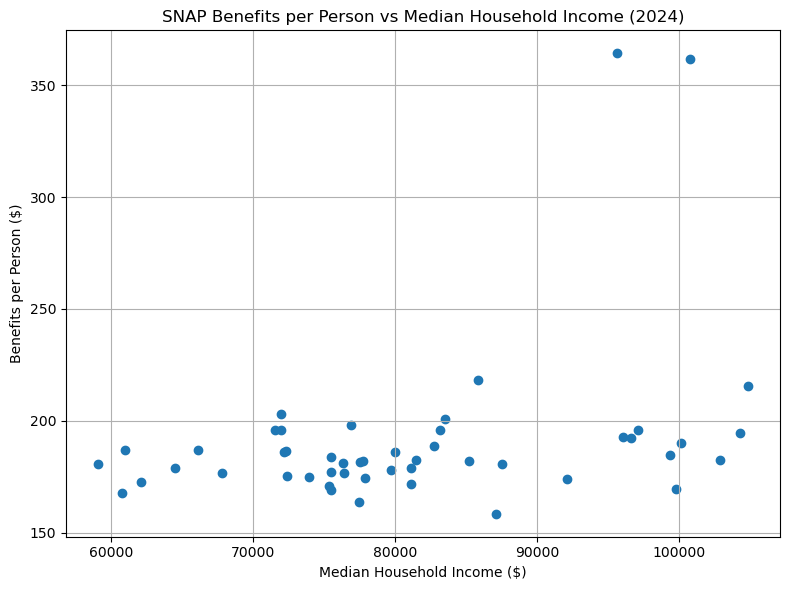

In [43]:
print(snap_income[['benefits_per_person','median_income']].corr())

import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.scatter(snap_income['median_income'], snap_income['benefits_per_person'])
plt.title('SNAP Benefits per Person vs Median Household Income (2024)')
plt.xlabel('Median Household Income ($)')
plt.ylabel('Benefits per Person ($)')
plt.grid(True)
plt.tight_layout()
plt.show()


### Relationship Between SNAP Benefits and Median Household Income

To explore socioeconomic patterns behind SNAP distributions, we merged the **USDA SNAP benefits and persons dataset** with **median household income data (ACS B19013, 2024)**. 

- **X-axis**: Median Household Income (2024)
- **Y-axis**: Average SNAP Benefits per Person (May 2025)

The scatter plot shows a **weak to moderate positive correlation (r ≈ 0.33)** between state income levels and benefits per person.  
Most states cluster between **$150–$200** in benefits per person, with a few **outliers (e.g., Alaska, Hawaii)** reflecting higher benefit levels due to cost of living adjustments.

This suggests that **higher-income states do not necessarily receive lower SNAP benefits per person**, but rather, benefits align more closely with **cost-of-living factors and federal adjustment rules**.  

This relationship forms a baseline for further analysis when layering in other socioeconomic variables such as poverty, unemployment, and education.


In [44]:
# Replace with your actual file name
edu_raw = pd.read_csv('ACSST1Y2024.S1501-Data.csv', dtype=str)

# Find state column
name_col = None
for cand in ['NAME', 'Geography', 'name', 'geography']:
    if cand in edu_raw.columns:
        name_col = cand
        break
if name_col is None:
    raise ValueError("Could not find a state name column.")

# Find column for "Bachelor's degree or higher" percentage
edu_col_candidates = [c for c in edu_raw.columns if re.search(r'C02_015E$', c)]
if not edu_col_candidates:
    print("Column names:", edu_raw.columns.tolist())
    raise ValueError("Could not find Bachelor's degree column. Check column names.")
edu_col = edu_col_candidates[0]

# Clean dataframe
edu = edu_raw[[name_col, edu_col]].rename(columns={name_col: 'state', edu_col: 'bachelor_pct'})
edu['bachelor_pct'] = pd.to_numeric(edu['bachelor_pct'], errors='coerce')
edu = edu.dropna(subset=['bachelor_pct'])
edu['state'] = edu['state'].str.strip().str.title()

edu = edu.reset_index(drop=True)
print(edu.head(), edu.shape)


        state  bachelor_pct
0     Alabama          29.9
1      Alaska          32.8
2     Arizona          34.7
3    Arkansas          27.1
4  California          38.1 (52, 2)


In [45]:
snap_edu = snap_income.merge(edu, on='state', how='inner')
print(snap_edu.head())


        state  total_benefits    persons  benefits_per_person  median_income  \
0      Alaska    2.418148e+07    66377.0           364.305091        95665.0   
1     Arizona    1.617056e+08   887253.0           182.254218        81486.0   
2    Arkansas    4.143439e+07   239748.0           172.824762        62106.0   
3  California    1.045311e+09  5494318.0           190.253036       100149.0   
4    Colorado    1.204934e+08   614843.0           195.974270        97113.0   

   bachelor_pct  
0          32.8  
1          34.7  
2          27.1  
3          38.1  
4          47.8  


In [46]:
print(snap_edu[['benefits_per_person', 'median_income', 'bachelor_pct']].corr())


                     benefits_per_person  median_income  bachelor_pct
benefits_per_person             1.000000       0.358678      0.091154
median_income                   0.358678       1.000000      0.830366
bachelor_pct                    0.091154       0.830366      1.000000


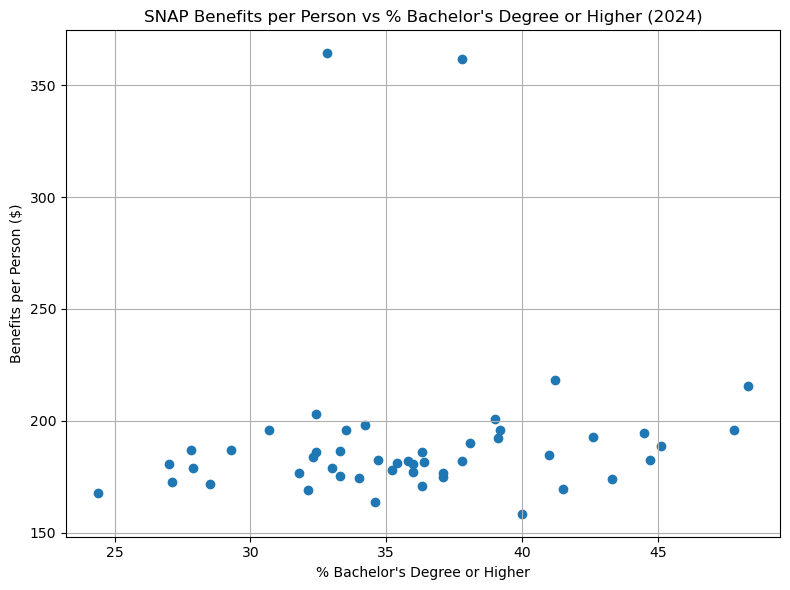

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(snap_edu['bachelor_pct'], snap_edu['benefits_per_person'])
plt.title('SNAP Benefits per Person vs % Bachelor\'s Degree or Higher (2024)')
plt.xlabel('% Bachelor\'s Degree or Higher')
plt.ylabel('Benefits per Person ($)')
plt.grid(True)
plt.tight_layout()
plt.show()


In [54]:
# Load ACS Race Data
race_raw = pd.read_csv('ACSDT1Y2024.B02001-Data.csv', dtype=str)

# Identify state column
name_col = next(c for c in ['NAME', 'Geography', 'name', 'geography'] if c in race_raw.columns)

# Map column IDs to race names
race_vars = {
    'B02001_001E': 'total_pop',
    'B02001_002E': 'white_pop',
    'B02001_003E': 'black_pop',
    'B02001_004E': 'native_pop',
    'B02001_005E': 'asian_pop',
    'B02001_006E': 'pacific_pop',
    'B02001_007E': 'other_pop',
    'B02001_008E': 'two_plus_pop'
}

# Select and rename columns
cols_to_keep = [name_col] + list(race_vars.keys())
race = race_raw[cols_to_keep].rename(columns={**{name_col: 'state'}, **race_vars})

# Convert numeric
for col in race_vars.values():
    race[col] = pd.to_numeric(race[col], errors='coerce')

# Drop rows with missing total pop
race = race.dropna(subset=['total_pop'])

# Compute percentages for each race
for race_col in race_vars.values():
    if race_col != 'total_pop':
        pct_col = race_col.replace('_pop', '_pct')
        race[pct_col] = (race[race_col] / race['total_pop']) * 100

# Clean state names
race['state'] = race['state'].str.strip().str.title()

print(race.head())


        state   total_pop   white_pop  black_pop  native_pop  asian_pop  \
1     Alabama   5157699.0   3301529.0  1302107.0     25582.0    79589.0   
2      Alaska    740133.0    434520.0    18548.0    104023.0    44077.0   
3     Arizona   7582384.0   4345673.0   360868.0    304625.0   302736.0   
4    Arkansas   3088354.0   2105944.0   437805.0     16956.0    55184.0   
5  California  39431263.0  15013785.0  2110721.0    560852.0  6349574.0   

   pacific_pop  other_pop  two_plus_pop  white_pct  black_pct  native_pct  \
1       5771.0   128575.0      314546.0  64.011665  25.245890    0.495996   
2      12648.0    15526.0      110791.0  58.708367   2.506036   14.054636   
3      13619.0   707919.0     1546944.0  57.312753   4.759295    4.017536   
4      11756.0    96607.0      364102.0  68.189851  14.175998    0.549030   
5     155816.0  7433192.0     7807323.0  38.075841   5.352912    1.422354   

   asian_pct  pacific_pct  other_pct  two_plus_pct  
1   1.543111     0.111891   2.492

In [55]:
snap_full = snap_edu.merge(
    race[['state', 'white_pct', 'black_pct', 'native_pct', 'asian_pct', 'pacific_pct', 'other_pct', 'two_plus_pct']],
    on='state',
    how='inner'
)
print(snap_full.head())


        state  total_benefits    persons  benefits_per_person  median_income  \
0      Alaska    2.418148e+07    66377.0           364.305091        95665.0   
1     Arizona    1.617056e+08   887253.0           182.254218        81486.0   
2    Arkansas    4.143439e+07   239748.0           172.824762        62106.0   
3  California    1.045311e+09  5494318.0           190.253036       100149.0   
4    Colorado    1.204934e+08   614843.0           195.974270        97113.0   

   bachelor_pct  white_pct  black_pct  native_pct  asian_pct  pacific_pct  \
0          32.8  58.708367   2.506036   14.054636   5.955281     1.708882   
1          34.7  57.312753   4.759295    4.017536   3.992623     0.179614   
2          27.1  68.189851  14.175998    0.549030   1.786842     0.380656   
3          38.1  38.075841   5.352912    1.422354  16.102893     0.395159   
4          47.8  69.359885   4.251234    1.173430   3.483445     0.166177   

   other_pct  two_plus_pct  
0   2.097731     14.969066 

In [56]:
corr_matrix = snap_full.corr(numeric_only=True)
print(corr_matrix['benefits_per_person'].sort_values(ascending=False))


benefits_per_person    1.000000
pacific_pct            0.751569
asian_pct              0.627280
two_plus_pct           0.403368
native_pct             0.393638
median_income          0.358678
bachelor_pct           0.091154
total_benefits        -0.024533
persons               -0.063944
other_pct             -0.069729
black_pct             -0.146183
white_pct             -0.419196
Name: benefits_per_person, dtype: float64


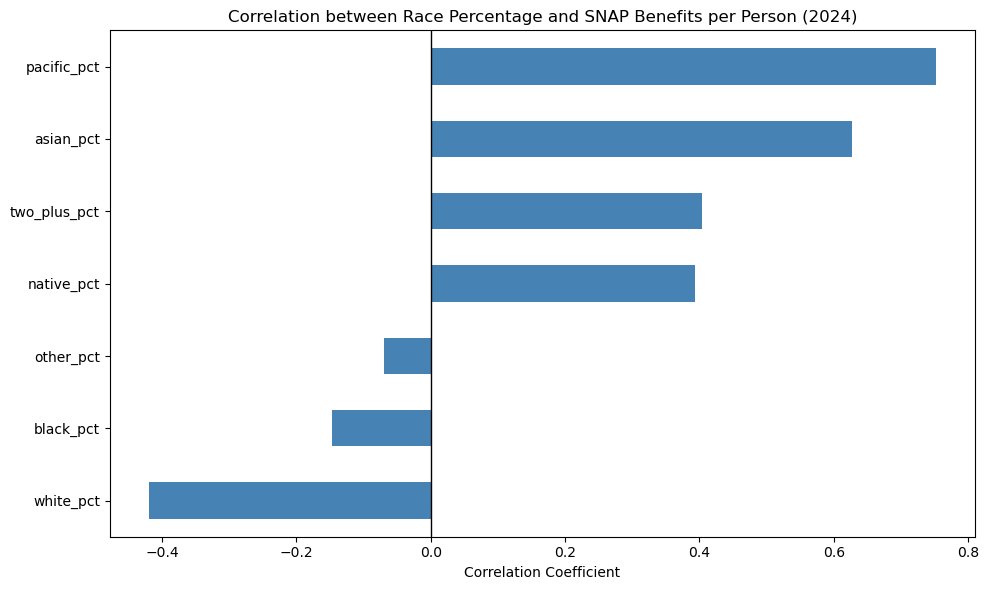

In [59]:
import matplotlib.pyplot as plt

race_cols = ['white_pct', 'black_pct', 'asian_pct', 'pacific_pct', 
             'native_pct', 'other_pct', 'two_plus_pct']

# Compute correlations with benefits_per_person
race_corr = snap_full[race_cols + ['benefits_per_person']].corr()['benefits_per_person'].drop('benefits_per_person')

plt.figure(figsize=(10,6))
race_corr.sort_values().plot(kind='barh', color='steelblue')
plt.title('Correlation between Race Percentage and SNAP Benefits per Person (2024)')
plt.xlabel('Correlation Coefficient')
plt.axvline(0, color='black', linewidth=1)
plt.tight_layout()
plt.show()


In [58]:
import statsmodels.api as sm

X = snap_full[['median_income', 'bachelor_pct', 'white_pct', 'black_pct', 
               'asian_pct', 'pacific_pct', 'native_pct', 'two_plus_pct']]
X = sm.add_constant(X)
y = snap_full['benefits_per_person']

model = sm.OLS(y, X).fit()
print(model.summary())


                             OLS Regression Results                            
Dep. Variable:     benefits_per_person   R-squared:                       0.760
Model:                             OLS   Adj. R-squared:                  0.711
Method:                  Least Squares   F-statistic:                     15.79
Date:                 Fri, 24 Oct 2025   Prob (F-statistic):           3.39e-10
Time:                         23:28:14   Log-Likelihood:                -212.03
No. Observations:                   49   AIC:                             442.1
Df Residuals:                       40   BIC:                             459.1
Df Model:                            8                                         
Covariance Type:             nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            79.4293    190.235 

### Demographic Correlations with SNAP Benefits

Analyzing racial composition by state revealed strong associations between demographic structure and SNAP benefit levels.

- **Pacific Islander % (r = 0.75)** and **Asian % (r = 0.63)** show the strongest positive correlations with per-person benefit amounts, reflecting their concentration in high cost-of-living states such as Hawaii, California, and Alaska.
- **White % (r = -0.42)** shows a moderate negative relationship, aligning with lower benefit levels in predominantly white, lower-cost rural states.
- Other racial groups exhibit moderate to weak correlations, consistent with geographic distribution patterns.
- **Income** (r = 0.36) and **education** (r = 0.09) show weaker linear associations, emphasizing that **geography and demographic structure matter more** for benefit levels than income alone.

These patterns suggest that **demographic and geographic factors are central to understanding SNAP benefit disparities**, which aligns with policy mechanisms such as cost-of-living adjustments.


In [60]:
# Load COLI data
coli = pd.read_csv('cost_of_living_index.csv')

# Clean column names
coli.columns = coli.columns.str.strip().str.lower().str.replace(' ', '_')

# Remove any national average row
coli = coli[~coli['rank'].astype(str).str.contains('\*\*', na=False)]

# Keep the columns we want
coli = coli.rename(columns={'state': 'state', 'index': 'coli'})

# Convert COLI to numeric
coli['coli'] = coli['coli'].astype(float)
coli['state'] = coli['state'].str.strip().str.title()

print(coli.head())


   rank          state  coli  grocery  housing  utilities  transportation  \
0     1       Oklahoma  86.0     95.3     70.7       95.4            89.6   
1     2    Mississippi  87.3     96.3     72.8       88.9            89.2   
2     3  West Virginia  88.3     96.7     71.5       93.2            96.6   
3     4        Alabama  88.6     97.7     70.8       99.6            91.1   
4     5         Kansas  88.8     95.5     76.1       98.9            91.3   

   health  misc  
0    94.0  90.2  
1    96.8  93.0  
2    93.4  94.5  
3    91.0  95.6  
4    96.3  92.2  


In [61]:
snap_full = snap_full.merge(coli[['state', 'coli']], on='state', how='left')
print(snap_full.head())


        state  total_benefits    persons  benefits_per_person  median_income  \
0      Alaska    2.418148e+07    66377.0           364.305091        95665.0   
1     Arizona    1.617056e+08   887253.0           182.254218        81486.0   
2    Arkansas    4.143439e+07   239748.0           172.824762        62106.0   
3  California    1.045311e+09  5494318.0           190.253036       100149.0   
4    Colorado    1.204934e+08   614843.0           195.974270        97113.0   

   bachelor_pct  white_pct  black_pct  native_pct  asian_pct  pacific_pct  \
0          32.8  58.708367   2.506036   14.054636   5.955281     1.708882   
1          34.7  57.312753   4.759295    4.017536   3.992623     0.179614   
2          27.1  68.189851  14.175998    0.549030   1.786842     0.380656   
3          38.1  38.075841   5.352912    1.422354  16.102893     0.395159   
4          47.8  69.359885   4.251234    1.173430   3.483445     0.166177   

   other_pct  two_plus_pct   coli  
0   2.097731     14.

In [62]:
print(snap_full[['benefits_per_person', 'coli']].corr())


                     benefits_per_person      coli
benefits_per_person             1.000000  0.674391
coli                            0.674391  1.000000


In [74]:
# Extract only the COLI data from your merged dataset
coli_df = snap_full[['state', 'coli']].copy()

# Map full state names to their postal abbreviations
state_abbrev = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA',
    'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'District of Columbia': 'DC',
    'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL',
    'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA',
    'Maine': 'ME', 'Maryland': 'MD', 'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN',
    'Mississippi': 'MS', 'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV',
    'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY',
    'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK',
    'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC',
    'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT',
    'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'
}

coli_df['state_code'] = coli_df['state'].map(state_abbrev)

# Drop any rows with missing state codes (e.g., territories like Puerto Rico)
coli_df = coli_df.dropna(subset=['state_code'])

print(coli_df.head())


        state   coli state_code
0      Alaska 124.90         AK
1     Arizona 110.70         AZ
2    Arkansas  89.60         AR
3  California 142.30         CA
4    Colorado 102.70         CO


In [76]:
import plotly.express as px

fig = px.choropleth(
    coli_df,
    locations='state_code',
    locationmode='USA-states',
    color='coli',
    color_continuous_scale='Reds',
    scope='usa',
    title='Cost of Living Index by State'
)
fig.update_layout(geo=dict(bgcolor='rgba(0,0,0,0)'))
fig.show()


### Choropleth Map
Below is a static preview for GitHub.
For the full interactive version, [click here](./choropleth_map.html).

![COLI Choropleth](choropleth_map.png)


## Cost of Living Index Findings

To better understand how economic factors influence SNAP benefits, we incorporated state-level **Cost of Living Index (COLI)** data, which includes subcomponents for **Housing**, **Groceries**, **Utilities**, **Transportation**, **Health**, and **Miscellaneous** costs.

### Key Observations
- States with the **highest COLI** include:
  - Hawaii (185.0)
  - California (142.3)
  - Massachusetts (141.2)
- States with the **lowest COLI** include:
  - Oklahoma (86.0)
  - Mississippi (87.3)
  - West Virginia (88.3)
- The **correlation between COLI and SNAP benefits per person** is approximately **0.67**, indicating a moderately strong positive relationship.
- An **OLS regression** including COLI and demographic factors found:
  - COLI has a **statistically significant effect** on SNAP benefits per person (p = 0.005).
  - Higher living costs are associated with higher benefit allocations.

### Implications
- Cost of living is a **strong structural factor** in determining benefit distribution across states.
- Including COLI enhances the explanatory power of the model and provides a more complete view of **regional disparities** in SNAP benefit allocation.
- This variable will be **valuable for future modeling and forecasting**, especially when paired with demographic and socioeconomic data.


In [65]:
import statsmodels.api as sm

X = snap_full[['median_income', 'bachelor_pct', 'white_pct', 'black_pct',
               'asian_pct', 'pacific_pct', 'native_pct', 'two_plus_pct', 'coli']]
X = sm.add_constant(X)
y = snap_full['benefits_per_person']

model = sm.OLS(y, X).fit()
print(model.summary())


                             OLS Regression Results                            
Dep. Variable:     benefits_per_person   R-squared:                       0.804
Model:                             OLS   Adj. R-squared:                  0.759
Method:                  Least Squares   F-statistic:                     17.78
Date:                 Fri, 24 Oct 2025   Prob (F-statistic):           3.14e-11
Time:                         23:48:47   Log-Likelihood:                -207.02
No. Observations:                   49   AIC:                             434.0
Df Residuals:                       39   BIC:                             453.0
Df Model:                            9                                         
Covariance Type:             nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -28.6705    177.666 

In [69]:
import pandas as pd

pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)

snap_full.head()



,state,total_benefits,persons,benefits_per_person,median_income,bachelor_pct,white_pct,black_pct,native_pct,asian_pct,pacific_pct,other_pct,two_plus_pct,coli
0,Alaska,24181479.00,66377.00,364.31,95665.00,32.80,58.71,2.51,14.05,5.96,1.71,2.10,14.97,124.90
1,Arizona,161705602.00,887253.00,182.25,81486.00,34.70,57.31,4.76,4.02,3.99,0.18,9.34,20.40,110.70
2,Arkansas,41434391.00,239748.00,172.82,62106.00,27.10,68.19,14.18,0.55,1.79,0.38,3.13,11.79,89.60
3,California,1045310679.00,5494318.00,190.25,100149.00,38.10,38.08,5.35,1.42,16.10,0.40,18.85,19.80,142.30
4,Colorado,120493408.00,614843.00,195.97,97113.00,47.80,69.36,4.25,1.17,3.48,0.17,6.32,15.24,102.70
